# Fluxonium properties

This notebook describes basic properties of a fluxonium circuit

## Import

In [348]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
import plotting_settings

In [349]:
%matplotlib inline

In [350]:
%pwd

'/Users/longnguyen/Documents/GitHub/Fluxonium/Scripts'

## Qubit parameters

In [351]:
N = 30 #number of levels
E_J = 12 #Josephson energy, GHz
E_C = 1 #Charging energy, GHz
E_L = 1 #Inductive energy, GHz
level_num = 10
phi_ext = np.linspace(0,1,201)
energies = np.zeros((len(phi_ext), level_num))
max_display_y = 10

## Spectrum

In [352]:
for idx, phi in enumerate(phi_ext):
    H = fluxonium.bare_hamiltonian(N, E_L, E_C, E_J, phi*2*np.pi)
    for idy in range(level_num):
        energies[idx,idy] = H.eigenenergies()[idy]

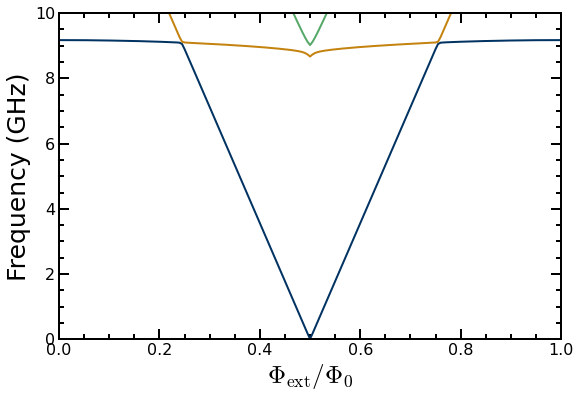

In [353]:
plt.figure(figsize=[9,6])
plt.xlim([phi_ext[0], phi_ext[-1]])
plt.ylim([0,max_display_y])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel('Frequency (GHz)')
for idx in range(1,level_num):
    plt.plot(phi_ext, energies[:,idx]-energies[:,0], linewidth = '2')

## Matrix elements

In [354]:
toCompute = 3 #Number of transitions to compute
n_me = np.zeros((len(phi_ext), toCompute), dtype = complex)
p_me = np.zeros_like(n_me)

for idx, phi in enumerate(phi_ext):
    n_me[idx, 0] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 1)
    p_me[idx, 0] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 1)
    n_me[idx, 1] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 2, 1)
    p_me[idx, 1] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 2, 1)
    n_me[idx, 2] = fluxonium.charge_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 2)
    p_me[idx, 2] = fluxonium.phase_matrix_element(N, E_L, E_C, E_J, phi*2*np.pi, 0, 2)

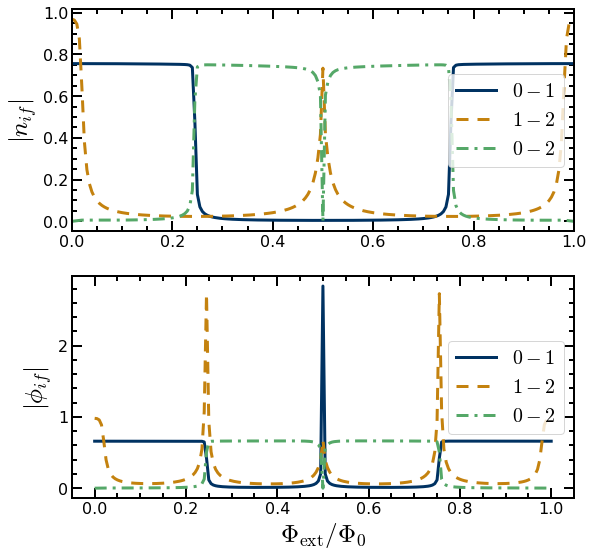

In [355]:
fig, (ax1, ax2) = plt.subplots(2, figsize=[9,9])
ax1.set_xlim([phi_ext[0], phi_ext[-1]])
ax2.set_xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
ax1.set_ylabel(r'$|n_{if}|$')
ax2.set_ylabel(r'$|\phi_{if}|$')
ax1.plot(phi_ext, abs(n_me[:, 0]), linewidth = '3', label = r'$0-1$')
ax2.plot(phi_ext, abs(p_me[:, 0]), linewidth = '3', label = r'$0-1$')
ax1.plot(phi_ext, abs(n_me[:, 1]), linewidth = '3', linestyle = '--', label = r'$1-2$')
ax2.plot(phi_ext, abs(p_me[:, 1]), linewidth = '3', linestyle = '--', label = r'$1-2$')
ax1.plot(phi_ext, abs(n_me[:, 2]), linewidth = '3', linestyle = '-.', label = r'$0-2$')
ax2.plot(phi_ext, abs(p_me[:, 2]), linewidth = '3', linestyle = '-.', label = r'$0-2$')
ax1.legend(loc='best')
ax2.legend(loc='right')

## Dispersive shifts 
First, simulate dispersive shift across the flux range

In [356]:
iState = 0
fState = 1
g = 0.1 #Coupling to cavity, GHz
w_R = 7.5 #Readout frequency, GHz
chi_01 = np.zeros_like(phi_ext)
for idx, phi in enumerate(phi_ext):
    chi_01[idx]= fluxonium.charge_dispersive_shift(N, level_num, E_L, E_C, E_J, phi*2*np.pi, iState, fState, w_R, g)

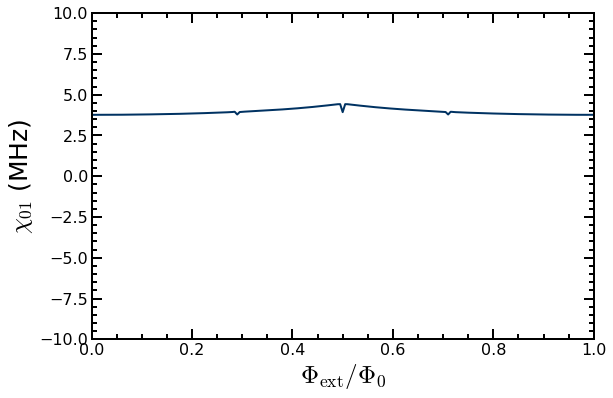

In [357]:
plt.figure(figsize=[9,6])
plt.xlim([phi_ext[0], phi_ext[-1]])
plt.ylim([-10,10])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel(r'$\chi_{01}$ (MHz)')
plt.plot(phi_ext, chi_01*1e3, linewidth = '2')

Simulate dispersive shift with varying resonator frequency

In [358]:
iState = 0
fState = 1
g = 0.1 #Coupling to cavity, GHz
w_R_array = np.linspace(4,10,101) #Readout frequency, GHz
chi_R_01 = np.zeros_like(w_R_array)
for idx, w_R in enumerate(w_R_array):
    chi_R_01[idx]= fluxonium.charge_dispersive_shift(N, level_num, E_L, E_C, E_J, np.pi, iState, fState, w_R, g)

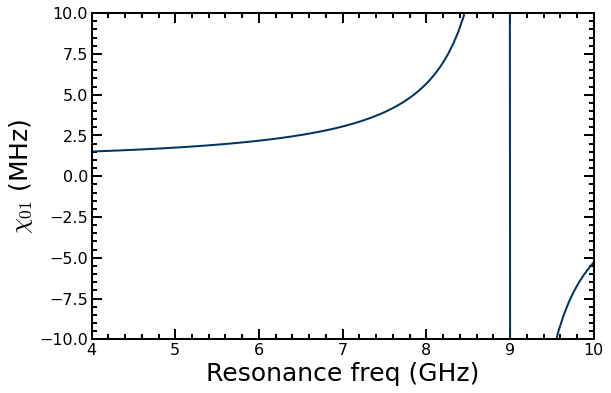

In [359]:
plt.figure(figsize=[9,6])
plt.xlim([w_R_array[0], w_R_array[-1]])
plt.ylim([-10,10])
plt.xlabel(r'Resonance freq (GHz)')
plt.ylabel(r'$\chi_{01}$ (MHz)')
plt.plot(w_R_array, chi_R_01*1e3, linewidth = '2')

## Energy relaxation

### Dielectric loss

In [360]:
freq = energies[:,1]-energies[:,0]
h = 6.626e-34 #Planck constant
kB = 1.38e-23 #Boltzmann constant
T_diel = 20e-3 #effective temperature in K
thermal_factor_diel = (1+np.exp(-h*freq*1e9/(kB*T_diel)))
Q_cap_array = [3e6]
gamma_cap  = np.zeros((len(phi_ext), len(Q_cap_array)), dtype = complex)

for Q_idx, Q_cap in enumerate(Q_cap_array):
    for phi_idx in range(len(phi_ext)):
        gamma_cap[phi_idx, Q_idx] = fluxonium.relaxation_rate_cap(E_L, E_C, E_J, Q_cap*(6.0/freq[phi_idx])**0.15, 
                                                                  freq[phi_idx], p_me[phi_idx,0], T_diel)*thermal_factor_diel[phi_idx]

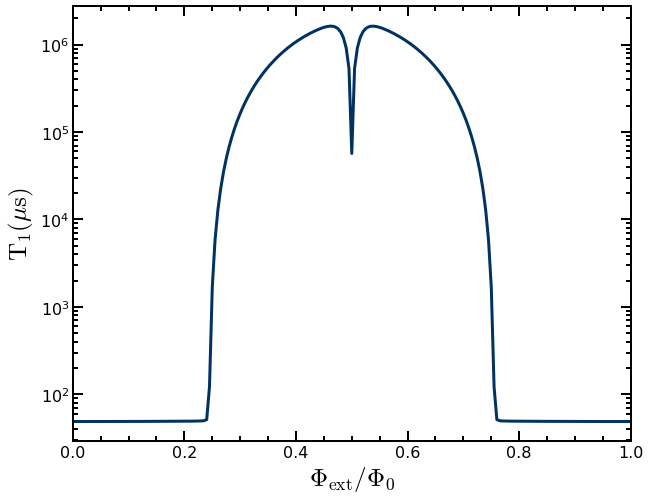

In [365]:
plt.figure(figsize = [10,8])
# plt.ylim([10,3000])
plt.xlim([phi_ext[0], phi_ext[-1]])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel('$\mathrm{T_1(\mu s)}$')
for idx in range (len(Q_cap_array)):
    plt.semilogy(phi_ext, 1.0/abs(gamma_cap[:,idx]) *1e6, linewidth= 3.0, linestyle ='-')

### Quasiparticles near small junction


In [362]:
#Quasiparticle tunneling across small junction
T_qp = 20e-3 #effective temperature in K
thermal_factor_qp = (1+np.exp(-h*freq*1e9/(kB*T_qp)))
Q_qp_array = [1e8]

### Quasiparticles in the array

In [363]:
#Quasiparticle in JJ array
T_qp = 20e-3 #effective temperature in K
thermal_factor_qp = (1+np.exp(-h*freq*1e9/(kB*T_qp)))
Q_qp_array = [1e9]
gamma_qp = np.zeros((len(phi_ext), len(Q_qp_array)), dtype=complex)
for Q_idx, Q_qp in enumerate(Q_qp_array):
    for phi_idx in range(len(phi_ext)):
        gamma_qp[phi_idx, Q_idx] = fluxonium.relaxation_rate_qp_array(E_L, E_C, E_J, Q_qp, freq[phi_idx], p_me[phi_idx,0])*thermal_factor_qp[phi_idx]

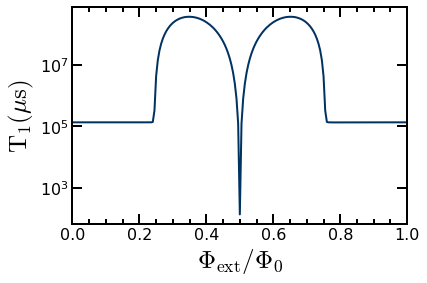

In [364]:
# plt.figure(figsize = [10,8])
# plt.ylim([10,1000])
plt.xlim([phi_ext[0], phi_ext[-1]])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel('$\mathrm{T_1(\mu s)}$')
for idx in range (len(Q_qp_array)):
    plt.semilogy(phi_ext, 1.0/abs(gamma_qp[:,idx]) *1e6, linewidth= 2.0, linestyle ='-')